In [16]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input,UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from alibi.explainers import CEM
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.11.0
Eager execution enabled:  False


x_train shape: (60000, 28, 28) y_train shape: (60000,)


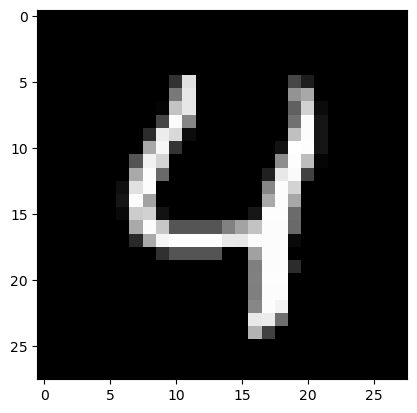

In [17]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[4])

In [18]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [19]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin)+ xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

In [20]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn

In [21]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1)
cnn.save('mnist_cnn.h5', save_format='h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                       

In [22]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test accuracy:  0.9867


In [23]:
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [24]:
ae = ae_model()
ae.summary()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test),verbose=0)
ae.save('mnist_ae.h5', save_format='h5')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 1)         145       
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 16)        160       
                                                           

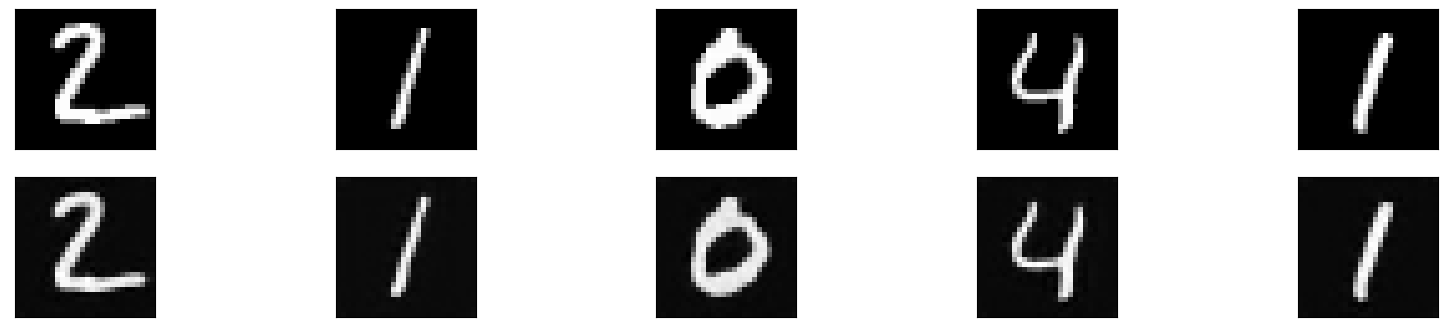

In [35]:
ae = load_model('mnist_ae.h5')
decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
# display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
 idx = 15
X = x_test[idx].reshape((1,) + x_test[idx].shape)

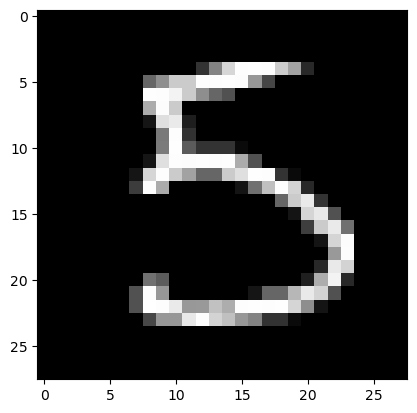

In [27]:
plt.imshow(X.reshape(28, 28));

In [28]:
 cnn.predict(X).argmax(), cnn.predict(X).max()

(5, 0.9998988)

In [29]:
mode = 'PN' # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:] # instance shape
kappa = 0. # minimum difference needed between the prediction probability for the perturbed instance on the
# class predicted by the original instance and the max probability on the other classes
# in order for the first loss term to be minimized
beta = .1 # weight of the L1 loss term
gamma = 100 # weight of the optional auto-encoder loss term
c_init = 3. # initial weight c of the loss term encouraging to predict a different class (PN) or
# the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10 # nb of updates for c
max_iterations = 1000 # nb of iterations per value of c
feature_range = (x_train.min(),x_train.max()) # feature range for the perturbed instance
clip = (-1000.,1000.) # gradient clipping
lr = 1e-2 # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
# perturbations towards this value means removing features, and away means adding features
# for our MNIST images, the background (-0.5) is the least informative,
# so positive/negative perturbations imply adding/removing features

In [30]:
# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)
explanation = cem.explain(X)#no_info_val=no_info_val으로 지정되어 있으므로 cem.fit이 불필요함

Pertinent negative prediction: 8


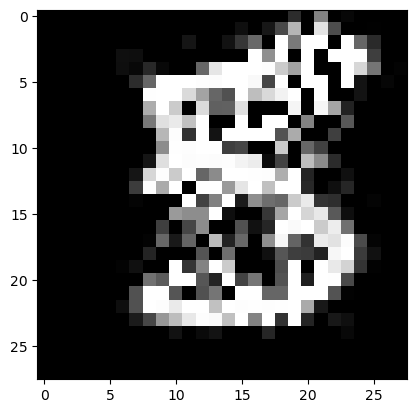

In [31]:
print(f'Pertinent negative prediction: {explanation.PN_pred}')
plt.imshow(explanation.PN.reshape(28, 28));

In [32]:
mode = 'PP'

In [33]:
 # initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
gamma=gamma, ae_model=ae, max_iterations=max_iterations,
c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)
explanation = cem.explain(X)

Pertinent positive prediction: 5


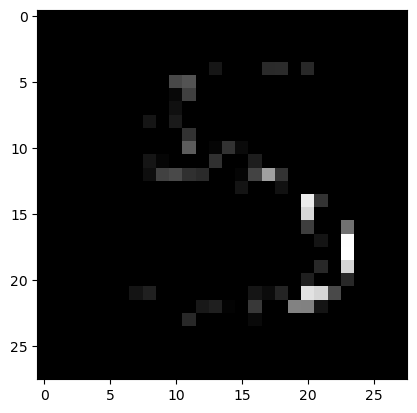

In [37]:
print(f'Pertinent positive prediction: {explanation.PP_pred}')
plt.imshow(explanation.PP.reshape(28, 28)); #c_init 의 선택이 중요함.

In [67]:
os.remove('mnist_cnn.h5')
os.remove('mnist_ae.h5')